## Analyse des données clients et des performances des vendeurs chez [Olist](https://olist.com/)

**Contexte du Projet**

Ce projet a été réalisé dans le cadre de mon master en **Machine Learning Engineering**. Il s'inscrit dans une situation réelle où j'ai agi en tant que consultant pour [Olist](https://olist.com/), une entreprise brésilienne spécialisée dans la vente via marketplaces en ligne. Mon rôle consistait à développer des requêtes SQL pour répondre à des questions spécifiques liées à l’analyse des données clients et des performances des vendeurs. Ces requêtes vont servir à alimenter un dashboard de KPI's.

**Objectifs du Projet**

Le projet a visé à fournir des insights à [Olist](https://olist.com/) à travers plusieurs axes d'analyse :

1. **Analyse des Délai de Livraison** : Identifier les commandes récentes avec des retards significatifs pour évaluer la performance de livraison.
2. **Performance des Vendeurs** : Déterminer les vendeurs ayant généré un chiffre d'affaires important pour orienter les stratégies de partenariat.
3. **Engagement des Nouveaux Vendeurs** : Identifier les nouveaux vendeurs (moins de 3 mois) ayant déjà un volume élevé de ventes pour potentiellement renforcer les relations commerciales.
4. **Analyse des Avis Clients** : Trouver les codes postaux avec le pire score moyen d'avis pour cibler les améliorations dans les zones problématiques.

1. [Libraries and Settings](#1) <br>    
2. [Database connection](#2) <br>
3. [Requêtes](#2) <br>
    - 3.1 [Requête 1: Analyse des délais de livraison](#31)<br>
    - 3.2 [Requête 1: Performance des vendeurs](#32)<br>
    - 3.3 [Requête 1: Engagement des nouveux vendeurs](#33)<br>
    - 3.4 [Requête 1: Analyse des avis clients](#34)<br>
   

### 1. Libraries & Settings <a id='1'></a>

In [19]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
sns.set_style("darkgrid")
sns.set_palette("vlag") 
#sns.set_context("paper", font_scale=0.9, rc={"lines.linewidth": 2.5})
sns.set(rc={'axes.labelsize': 10, 'xtick.labelsize': 9, 'ytick.labelsize': 9, 'axes.labelcolor': 'gray', 'xtick.color': 'gray', 'ytick.color': 'gray'})

### 2. Database connection <a id='2'></a>

In [17]:
# Path to the db file
#db_path = 'C:/Users/Luciana/Documents/GitHub/Openclassrooms/Projet 4/olist.db'
db_path = 'C:/Users/lzeferino/Documents/GitHub/Openclassrooms/Projet 4/olist.db'  # Work computer

# Connect to the database
conn = sqlite3.connect(db_path)

# Create a cursor object
cursor = conn.cursor()

# Execute a query to list all tables in the db
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch and print the results
tables = cursor.fetchall()
print("Tables in the database:")
for table in tables:
    print(table[0])

Tables in the database:
customers
geoloc
order_items
order_pymts
order_reviews
orders
products
sellers
translation


### 3. Requêtes <a id='3'></a>

#### 3.1 Requête 1: Analyse des délais de livraison <a id='31'></a>
En excluant les commandes annulées, quelles sont les commandes récentes de moins de 3 mois que les clients ont reçues avec au moins 3 jours de retard ?

1. **Expression de Table Commune (CTE)** :
   - **Calcule `delivery_delay`** : Le délai en jours entre la date estimée de livraison et la date réelle de livraison.
   - **Trouve `max_order_date`** : La date de l'achat la plus récente dans l'ensemble de données.

2. **Requête Principale** :
   - **Filtres** :
     - Exclut les commandes dont le statut est 'canceled'.
     - Sélectionne les commandes des 3 derniers mois.
     - Inclut uniquement les commandes avec un délai de livraison de 3 jours ou plus.
   - **Retourne** : ID de la commande, statut, date d'achat et délai de livraison.
   - **Trie** : Par délai de livraison en ordre décroissant.

In [32]:
query = """
WITH cte as (
 SELECT 
    order_id, 
    customer_id, 
    order_status, 
    order_purchase_timestamp, 
    order_estimated_delivery_date, 
    order_delivered_customer_date, 
    CAST((julianday(date(order_delivered_customer_date)) - julianday(date(order_estimated_delivery_date))) AS INTEGER) AS delivery_delay,
    MAX(order_purchase_timestamp) OVER () AS max_order_date       
FROM 
    orders                     
) 
SELECT 
    order_id,      
    order_status, 
    order_purchase_timestamp,      
    delivery_delay      
FROM cte 
WHERE  order_status != 'canceled'
	AND order_purchase_timestamp >= date(max_order_date, '-3 months')
	AND delivery_delay >= 3
ORDER BY delivery_delay DESC
"""

cursor.execute(query)
results = cursor.fetchall()
columns = [
    'order_id',     
    'order_status', 
    'order_purchase_timestamp',     
    'delivery_delay'    
]
requete_1 = pd.DataFrame(results, columns=columns)
requete_1.head(5)

,order_id,order_status,order_purchase_timestamp,delivery_delay
0,b2997e1d7061605e9285496c581d1fbd,delivered,2018-07-30 09:08:06,49
1,a2b4be96b53022618030c17ed437604d,delivered,2018-07-22 09:54:03,41
2,238652e39c5fdf89a8fd44776f532501,delivered,2018-07-25 09:15:28,38
3,4af2fb154881f350d8696f7f7a7f80d3,delivered,2018-07-23 10:22:26,38
4,7d09831e67caa193da82cfea3bee7aa5,delivered,2018-08-05 17:11:44,36


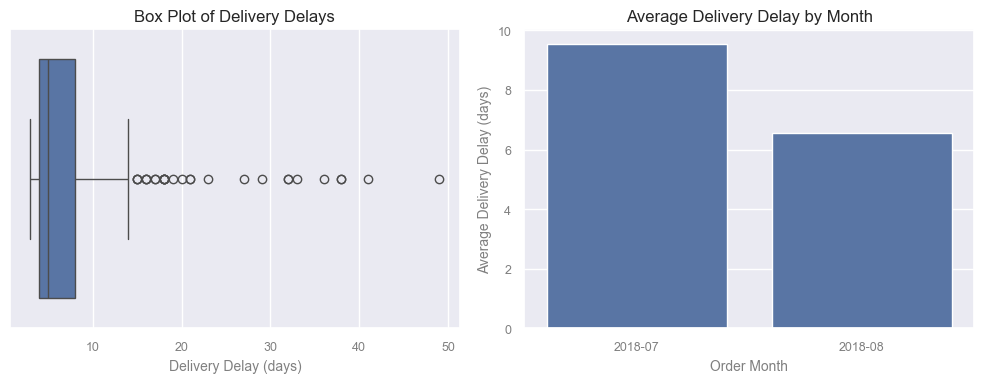

In [48]:
# Convert 'order_purchase_timestamp' to datetime
requete_1['order_purchase_timestamp'] = pd.to_datetime(requete_1['order_purchase_timestamp'])
requete_1['order_month'] = requete_1['order_purchase_timestamp'].dt.to_period('M')

# Average delivery delay by month
monthly_delay = requete_1.groupby('order_month')['delivery_delay'].mean().reset_index()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Box Plot
# Horizontal Box Plot
sns.boxplot(data=requete_1, x='delivery_delay', ax=axes[0], orient="h")
axes[0].set_title('Box Plot of Delivery Delays')
axes[0].set_xlabel('Delivery Delay (days)')  # Use xlabel for horizontal box plot

# Bar Plot
sns.barplot(data=monthly_delay, x='order_month', y='delivery_delay', ax=axes[1])
axes[1].set_title('Average Delivery Delay by Month')
axes[1].set_xlabel('Order Month')
axes[1].set_ylabel('Average Delivery Delay (days)')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#### 3.2 Requête 2: Performance des vendeurs <a id='32'></a>
Qui sont les vendeurs ayant généré un chiffre d'affaires de plus de 100000 Real sur des commandes livrées via Olist ?

1. **Expression de Table Commune (CTE)** :
   - **Sélectionne des données** : `oi.seller_id`, `oi.order_id`, et `oi.price` depuis la table `order_items`.
   - **Jointure avec la table `orders`** : Utilise une jointure gauche (`LEFT JOIN`) pour associer les commandes aux articles commandés.
   - **Filtrage** : Ne conserve que les commandes dont le statut est `'delivered'` (livré).

2. **Calcul du chiffre d'affaires des vendeurs** :
   - **Compte les commandes distinctes** (`number_orders`) et calcule le chiffre d'affaires total (`revenue`) pour chaque vendeur.
   - **Arrondit** le chiffre d'affaires à deux décimales.

3. **Filtrage final** :
   - **Sélectionne** les vendeurs ayant généré un chiffre d'affaires supérieur à 100 000 Real.
   - **Trie les résultats** par chiffre d'affaires en ordre décroissant.

In [12]:
query = """
WITH cte AS (
    SELECT 
        oi.seller_id,
        oi.order_id,
        oi.price 
    FROM order_items AS oi
    LEFT JOIN orders AS o ON o.order_id = oi.order_id
    WHERE o.order_status = 'delivered'
),
sellers_revenue AS (
    SELECT
        seller_id,
        COUNT(DISTINCT order_id) AS number_orders,
        ROUND(SUM(price), 2) AS revenue
    FROM cte
    GROUP BY seller_id
)
SELECT *
FROM sellers_revenue
WHERE revenue > 100000
ORDER BY revenue DESC;
"""

cursor.execute(query)
results = cursor.fetchall()
columns = [
    'seller_id', 
    'number_orders', 
    'revenue'    
]
requete_2 = pd.DataFrame(results, columns=columns)
requete_2

,seller_id,number_orders,revenue
0,4869f7a5dfa277a7dca6462dcf3b52b2,1124,224921.54
1,53243585a1d6dc2643021fd1853d8905,348,203364.00
2,fa1c13f2614d7b5c4749cbc52fecda94,578,190917.14
3,4a3ca9315b744ce9f8e9374361493884,1772,183828.07
4,7e93a43ef30c4f03f38b393420bc753a,319,165822.49
5,da8622b14eb17ae2831f4ac5b9dab84a,1311,141875.38
6,7c67e1448b00f6e969d365cea6b010ab,973,140998.62
7,7a67c85e85bb2ce8582c35f2203ad736,1145,139098.77
8,46dc3b2cc0980fb8ec44634e21d2718e,503,120671.54
9,6560211a19b47992c3666cc44a7e94c0,1819,116660.83


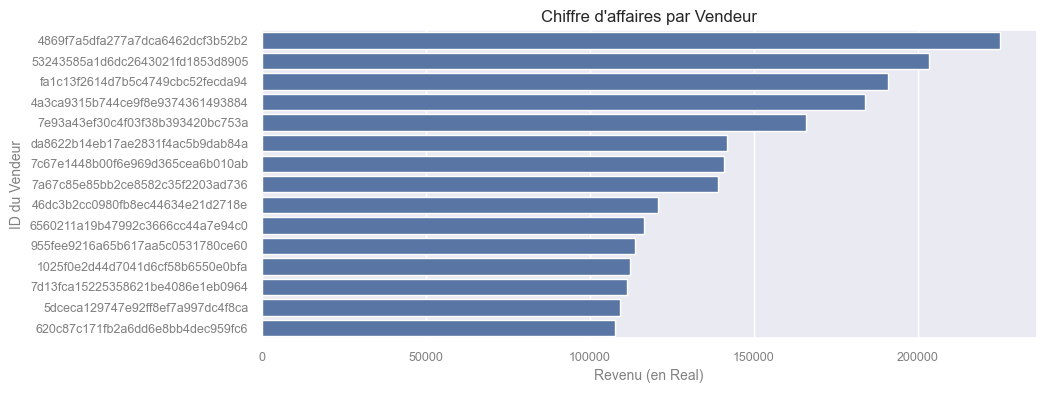

In [51]:
plt.figure(figsize=(10, 4))
# Bar Plot horizontal pour le revenu
sns.barplot(data=requete_2, y='seller_id', x='revenue')
plt.title('Chiffre d\'affaires par Vendeur')
plt.xlabel('Revenu (en Real)')
plt.ylabel('ID du Vendeur')
plt.show()

#### 3.3 Requête 3: Engagement des nouveux vendeurs <a id='33'></a>

Qui sont les nouveaux vendeurs (moins de 3 mois d'ancienneté) qui sont déjà très engagés avec la plateforme (ayant déjà vendu plus de 30 produits) ?

Observation: Nous n'avons pas la date d'inscription du vendeur sur la platform, donc j'ai considéré la première vente comme la date d'inscription.

1. **Expression de Table Commune (CTE)** :
   - **Sélection des informations par vendeur** :
     - `oi.seller_id` : Identifiant du vendeur.
     - `MIN(o.order_purchase_timestamp)` : La date de la première vente du vendeur, considérée comme sa date d'inscription.
     - `COUNT(oi.product_id)` : Nombre total de produits vendus par le vendeur.
     - `(SELECT MAX(order_purchase_timestamp) FROM orders)` : La date de la dernière commande dans la base de données, utilisée pour déterminer la période des 3 mois.

   - **Jointure avec `orders`** :
     - Jointure gauche (`LEFT JOIN`) pour associer les articles commandés aux commandes.
     - Filtre sur les commandes livrées (`WHERE o.order_status = 'delivered'`).

   - **Regroupement par vendeur** (`GROUP BY oi.seller_id`):
     - Compte les produits vendus et détermine la date de la première vente pour chaque vendeur.

2. **Requête Principale** :
   - **Filtrage** :
     - Inclut seulement les vendeurs dont la première vente a eu lieu dans les 3 derniers mois (`first_sale_date >= DATE(max_order_date, '-3 months')`).
     - Exclut les vendeurs ayant vendu 30 produits ou moins (`number_products > 30`).

   - **Tri** :
     - Trie les résultats par nombre de produits vendus en ordre décroissant (`ORDER BY number_products DESC`).

In [13]:
query = """
WITH cte AS (
    SELECT 
        oi.seller_id, 
        MIN(o.order_purchase_timestamp) AS first_sale_date,
        COUNT(oi.product_id) AS number_products,
        (SELECT MAX(order_purchase_timestamp) FROM orders) AS max_order_date
    FROM order_items AS oi
    LEFT JOIN orders AS o ON oi.order_id = o.order_id
    WHERE o.order_status = 'delivered'
    GROUP BY oi.seller_id
)
SELECT 
    seller_id, 
    first_sale_date, 
    number_products
FROM cte
WHERE first_sale_date >= DATE(max_order_date, '-3 months')
  AND number_products > 30
ORDER BY number_products DESC;
"""

cursor.execute(query)
results = cursor.fetchall()
columns = [
    'seller_id', 
    'first_sale_date', 
    'nb_products'    
]
requete_3 = pd.DataFrame(results, columns=columns)
requete_3

,seller_id,first_sale_date,nb_products
0,d13e50eaa47b4cbe9eb81465865d8cfc,2018-08-04 09:09:37,68
1,81f89e42267213cb94da7ddc301651da,2018-08-08 12:45:12,52
2,240b9776d844d37535668549a396af32,2018-07-17 13:48:59,35


#### 3.4 Requête 4: Analyse des avis clients <a id='34'></a>
Quels sont les 5 codes postaux, enregistrant plus de 30 reviews, avec le pire review score moyen sur les 12 derniers mois ?

1. **Expression de Table Commune (CTE)** :
   - **Sélection des informations des commandes** :
     - `o.order_id` : Identifiant de la commande.
     - `o.order_purchase_timestamp` : Date d'achat de la commande.
     - `c.customer_zip_code_prefix` : Préfixe du code postal du client.
     - `MAX(order_purchase_timestamp) OVER()` : Date de la dernière commande dans l’ensemble de données.

   - **Jointure avec `customers`** :
     - Jointure gauche (`LEFT JOIN`) pour associer les commandes aux clients.

2. **Calcul du score moyen des avis** :
   - **Sélectionne** :
     - `cte.customer_zip_code_prefix` : Préfixe du code postal du client.
     - `ROUND(AVG(ore.review_score),2)` : Score moyen des avis arrondi à deux décimales.
     - `COUNT(ore.review_score)` : Nombre total d'avis reçus pour chaque code postal.

   - **Filtrage** :
     - Seules les commandes effectuées dans les 12 derniers mois sont considérées (`cte.order_purchase_timestamp >= DATE(cte.max_purchase_date, '-12 months')`).

   - **Regroupement** :
     - Regroupe par préfixe de code postal (`GROUP BY cte.customer_zip_code_prefix`).

3. **Requête Principale** :
   - **Filtrage** :
     - Sélectionne les codes postaux ayant reçu plus de 30 avis (`number_reviews > 30`).

   - **Tri** :
     - Trie les résultats par score moyen des avis en ordre croissant (`ORDER BY avg_review_score`), montrant les pires scores en premier.

   - **Limitation** :
     - Limite les résultats aux 5 premiers codes postaux (`LIMIT 5`).

In [14]:
query = """
WITH cte AS (
    SELECT  
        o.order_id, 
        o.order_purchase_timestamp,
        c.customer_zip_code_prefix,
        MAX(order_purchase_timestamp) OVER() AS max_purchase_date
    FROM orders AS o
    LEFT JOIN customers AS c ON o.customer_id = c.customer_id
),
average_review_score AS (
    SELECT 
        cte.customer_zip_code_prefix,
        ROUND(AVG(ore.review_score),2) AS avg_review_score,
        COUNT(ore.review_score) AS number_reviews
    FROM order_reviews AS ore
    INNER JOIN cte ON ore.order_id = cte.order_id
    WHERE cte.order_purchase_timestamp >= DATE(cte.max_purchase_date, '-12 months')
    GROUP BY cte.customer_zip_code_prefix
)
SELECT * 
FROM average_review_score
WHERE number_reviews > 30
ORDER BY avg_review_score
LIMIT 5;
"""

cursor.execute(query)
results = cursor.fetchall()
columns = [
    'customer_zip_code_prefix', 
    'avg_review_score',
    'number_reviews'
]

# Fermeture de la connexion
conn.close()

requete_4 = pd.DataFrame(results, columns=columns)
requete_4

,customer_zip_code_prefix,avg_review_score,number_reviews
0,22753,2.81,47
1,22770,3.14,37
2,22793,3.23,90
3,21321,3.28,36
4,13295,3.35,31
